### Tasks
* Implement Faiss - (create a util file using code given by gaurav and import here) 
* Implement Near Neighbor Sampling 
* plot the gradients for each batch (==1, should be high) and for the entire dataset(should be low) at different interesting epochs 
* Figure out how to calculate efficient per sample gradient 


In [1]:
pip install faiss-cpu --no-cache

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.6 MB 12.8 MB/s 


In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random

#replace with pytorch lightning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from indx import *
from query import *

In [ ]:
print(torch.__version__)

1.12.1+cu113


In [84]:
df = pd.read_csv("winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


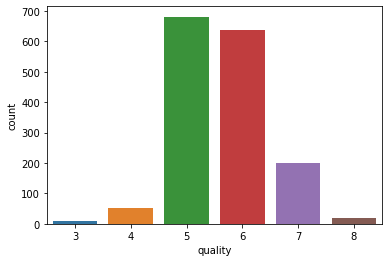

In [85]:
sns.countplot(x = 'quality', data=df)

In [ ]:
# query(13,1599,2,False,"vector_data.npy","vector_data.npy","COMP580_vector_data.npy",5)

In [86]:
class2idx = {
    3:0,
    4:1,
    5:2,
    6:3,
    7:4,
    8:5
}

idx2class = {v: k for k, v in class2idx.items()}

df['quality'].replace(class2idx, inplace=True)

In [ ]:
## Create Hash tables for different classes start with one table, choose k


In [87]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [88]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [89]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [90]:
TEMP=np.append(X_train,y_train[:,None],axis=1)
TEMP = TEMP[TEMP[:, -1].argsort()]
# print(np.unique(TEMP[:, -1], return_index=True)[1][:])
TEMP=np.split(TEMP, np.unique(TEMP[:, -1], return_index=True)[1][0:])

CLASSES=[]
for i in range(6):
  CLASSES.append(np.ascontiguousarray(TEMP[i+1]))
# CLASS0=np.ascontiguousarray(TEMP[1])
# CLASS1=np.ascontiguousarray(TEMP[2])
# CLASS2=np.ascontiguousarray(TEMP[3])
# CLASS3=np.ascontiguousarray(TEMP[4])
# CLASS4=np.ascontiguousarray(TEMP[5])
# CLASS5=np.ascontiguousarray(TEMP[6])


print(CLASSES[5])

[[0.05454545 0.25342466 0.03       0.06164384 0.05342237 0.40298507
  0.28621908 0.05359765 0.5984252  0.29341317 0.86153846 5.        ]
 [0.7        0.13013699 0.72       0.0890411  0.10016694 0.07462687
  0.08127208 0.63362702 0.11023622 0.29341317 0.21538462 5.        ]
 [0.27272727 0.15753425 0.46       0.18493151 0.11018364 0.20895522
  0.10954064 0.530837   0.48031496 0.31736527 0.67692308 5.        ]
 [0.33636364 0.20547945 0.39       0.06164384 0.09348915 0.07462687
  0.02120141 0.37371512 0.48031496 0.21556886 0.50769231 5.        ]
 [0.27272727 0.28767123 0.34       0.10958904 0.10684474 0.10447761
  0.03886926 0.16740088 0.36220472 0.23353293 0.72307692 5.        ]
 [0.00909091 0.20547945 0.24       0.07534247 0.08013356 0.26865672
  0.15547703 0.11967695 0.77165354 0.24550898 0.86153846 5.        ]
 [0.06363636 0.5        0.05       0.03424658 0.05509182 0.1641791
  0.28975265 0.17107195 0.64566929 0.29341317 0.69230769 5.        ]
 [0.40909091 0.12328767 0.56       0.13013

In [37]:
# TEMP=pd.DataFrame(X_train)
# TEMP["Class"]=pd.DataFrame(y_train)
# TEMP=TEMP.groupby(["Class"])
# CLASS0=TEMP.get_group(0).reset_index()
# CLASS1=TEMP.get_group(1).reset_index()
# CLASS2=TEMP.get_group(2).reset_index()
# CLASS3=TEMP.get_group(3).reset_index()
# CLASS4=TEMP.get_group(4).reset_index()
# CLASS5=TEMP.get_group(5).reset_index()



In [20]:

index(CLASSES[0][:,:-1],"IVF3,Flat","CLASS0")
index(CLASSES[1][:,:-1],"IVF3,Flat","CLASS1")
index(CLASSES[2][:,:-1],"IVF4,Flat","CLASS2")
index(CLASSES[3][:,:-1],"IVF5,Flat","CLASS3")
index(CLASSES[4][:,:-1],"IVF5,Flat","CLASS4")
index(CLASSES[5][:,:-1],"IVF6,Flat","CLASS5")


<class 'numpy.float32'>
traning
adding
ntotal after ivf:  7
total train time:  0.0054738521575927734
saving at  CLASS0
total code time:  0.007448673248291016
<class 'numpy.float32'>
traning
adding
ntotal after ivf:  38
total train time:  0.00650477409362793
saving at  CLASS1
total code time:  0.00673985481262207
<class 'numpy.float32'>
traning
adding
ntotal after ivf:  490
total train time:  0.002801656723022461
saving at  CLASS2
total code time:  0.0030753612518310547
<class 'numpy.float32'>
traning
adding
ntotal after ivf:  459
total train time:  0.012773513793945312
saving at  CLASS3
total code time:  0.01306295394897461
<class 'numpy.float32'>
traning
adding
ntotal after ivf:  143
total train time:  0.00961446762084961
saving at  CLASS4
total code time:  0.009868383407592773
<class 'numpy.float32'>
traning
adding
ntotal after ivf:  14
total train time:  0.003271341323852539
saving at  CLASS5
total code time:  0.003487110137939453


In [7]:
# print(type(X_train))
# l=X_train
# l = np.ascontiguousarray(l)
# np.save("vector_data",l);

In [8]:
# index(l,"IVF8,PQ1")

<class 'numpy.float32'>
traning
adding
ntotal after ivf:  1151
total train time:  11.814581155776978
saving at  ./COMP580
total code time:  11.817189931869507


In [26]:
# query(11,7,2,False,CLASSES[0][:,:-1],CLASSES[0][:,:-1],"CLASS0",2)

(array([[1.48492062, 1.32370675],
        [1.26127994, 1.24448729]]), array([[5., 0.],
        [6., 3.]]))

In [12]:
# query(13,1599,3,False,l,l,"COMP580",5)

(array([[1.55487955, 1.55487955, 1.55487955, 1.54713345, 1.42624784],
        [2.02503681, 2.02503681, 1.95495534, 1.95495534, 1.95495534],
        [1.39362013, 1.33699226, 1.27552605, 1.27552605, 1.27552605]]),
 array([[ 847.,  996.,  754.,  668.,  267.],
        [ 547., 1137.,  573.,  276.,  167.],
        [ 879.,  330.,  777.,  100.,  832.]]))

In [91]:
def get_class_distribution(obj):
    count_dict = {
        "rating_3": 0,
        "rating_4": 0,
        "rating_5": 0,
        "rating_6": 0,
        "rating_7": 0,
        "rating_8": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['rating_3'] += 1
        elif i == 1: 
            count_dict['rating_4'] += 1
        elif i == 2: 
            count_dict['rating_5'] += 1
        elif i == 3: 
            count_dict['rating_6'] += 1
        elif i == 4: 
            count_dict['rating_7'] += 1  
        elif i == 5: 
            count_dict['rating_8'] += 1              
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

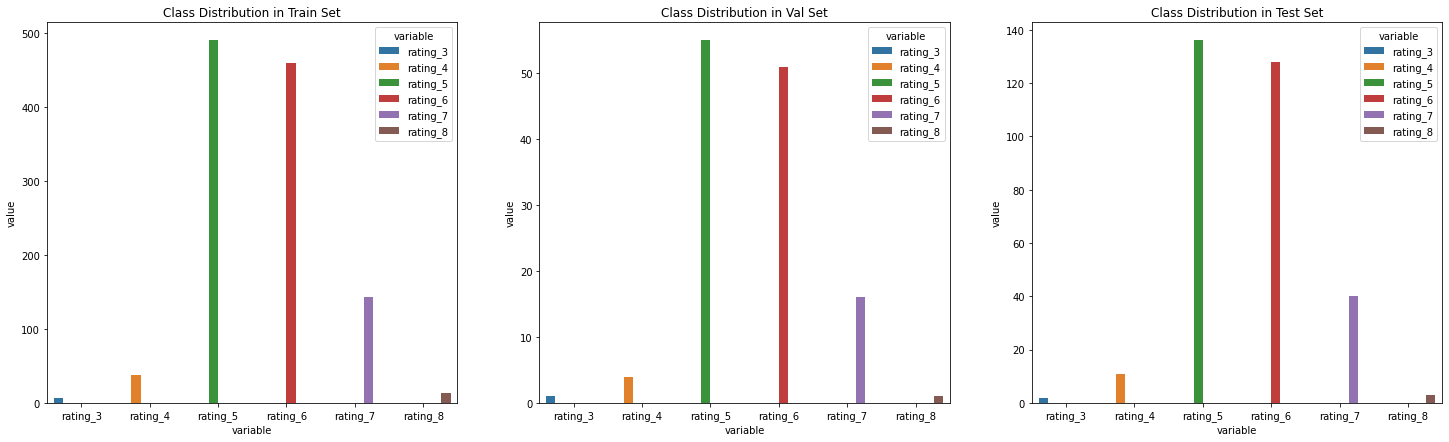

In [92]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [93]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [94]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)

In [95]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.1429, 0.0263, 0.0020, 0.0022, 0.0070, 0.0714])


In [96]:
class_weights_all = class_weights[target_list]

In [ ]:
## insert weighted sampler with your own sampler

In [97]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [134]:
EPOCHS = 6
BATCH_SIZE = 23
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 6

In [99]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [100]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [101]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=11, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=6, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [102]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [103]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [135]:
Max_step=1000

In [105]:
# !pip install -Uqq ipdb
# import ipdb

In [ ]:
# %pdb on

Automatic pdb calling has been turned ON


In [ ]:
# idx=np.empty((len(X_train),1))
# for i in range(len(idx)):
#   idx[i]= int(i)
# # idx=np.arange(0,1150,1)
# print(X_train[0])
# X_train=np.append(X_train, idx, axis=1)
# # print(len(X_train[0]))

[0.30909091 0.14383562 0.42       0.09589041 0.09682805 0.11940299
 0.04946996 0.30763583 0.50393701 0.26347305 0.66153846]


In [138]:
X_train_LSH=X_train[0:BATCH_SIZE,:]
y_train_LSH=y_train[0:BATCH_SIZE]
# print(y_train_LSH.dtype)

In [141]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    # step=0
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    step=0
    while(step<Max_step):
      X_train_batch= torch.from_numpy(X_train_LSH)
      # X_train_batch.to(torch.float64)
      y_train_batch=torch.from_numpy(y_train_LSH)
      # y_train_batch.to(torch.float64)
      # print(type(X_train_batch))
    # for X_train_batch, y_train_batch in train_loader:
    #     X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
      optimizer.zero_grad()
      # print(y_train_LSH.dtype)
      y_train_pred = model(X_train_batch.float())
      train_loss = criterion(y_train_pred, y_train_batch)
      
      #FOR GETTING INDIVIDUAL LOSSES
      with torch.no_grad():
        Y_TRAIN=nn.functional.one_hot(y_train_batch,num_classes=6);
        Y_PRED=nn.Softmax(dim=1)
        # print(y_train_pred.size())
        # print(Y_TRAIN)
        LOSS=torch.sum(-Y_TRAIN*torch.log(Y_PRED(y_train_pred)),1)
        LOSS=torch.reshape(LOSS,(-1,1))
        LOSS=LOSS.numpy();
        LOSS=np.append(LOSS, X_train_LSH, axis=1)
        LOSS=np.append(LOSS, y_train_LSH[:,None], axis=1)
        idx=LOSS[:, 0].argsort()
        
        T=[]
        for i in range(NUM_CLASSES):
            T.append([]);
        #TOP K LOSSES
        for i in range(10):
          # print(int(LOSS[idx[i]][-1]))
          T[int(LOSS[idx[i]][-1])].append(LOSS[idx[i]][1:-1])
        
        #QUERYING FROM FAISS AND ACCUMULATING
        tempbatch=[]
        for i in range(6):
          _,BUCKET=query(CLASSES[i].shape[1],CLASSES[i].shape[0],len(T[i]),False,np.array(T[i]),np.array(T[i]),f'CLASS{i}',1)
          for j in range(len(BUCKET)):
            # print(BUCKET)
            tempbatch.append(CLASSES[i][int(BUCKET[j])])
        
        ##CREATING NEW BATCH BY SAMPLING
        t=[random.choice(tempbatch) for _ in range(BATCH_SIZE)]
        t=np.array(t);
        X_train_LSH=t[:,:-1]
        y_train_LSH=t[:,-1].astype(np.int64)

        # raise Exception("Loss")
        # print(train_loss)
      ##############################

      train_acc = multi_acc(y_train_pred, y_train_batch)
      # print(train_loss)
      train_loss.backward()
      optimizer.step()
      
      train_epoch_loss += train_loss.item()
      train_epoch_acc += train_acc.item()
      step+=1
        ##CREATE THE NEW BATCHES AND UPDATE X_TRAIN_BATCH,Y_TRAIN_BATCH
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


Begin training.


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.00013 | Val Loss: 16846146.44922 | Train Acc: 1960.784| Val Acc: 12.500
Epoch 002: | Train Loss: 0.00007 | Val Loss: 17150397.59375 | Train Acc: 1960.784| Val Acc: 12.500
Epoch 003: | Train Loss: 0.00004 | Val Loss: 17088325.11719 | Train Acc: 1960.784| Val Acc: 12.500
Epoch 004: | Train Loss: 0.00003 | Val Loss: 17661339.21875 | Train Acc: 1960.784| Val Acc: 12.500
Epoch 005: | Train Loss: 0.00001 | Val Loss: 17499338.08984 | Train Acc: 1960.784| Val Acc: 12.500
Epoch 006: | Train Loss: 0.00001 | Val Loss: 17813363.87891 | Train Acc: 1960.784| Val Acc: 12.500


In [ ]:
%pdb off

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

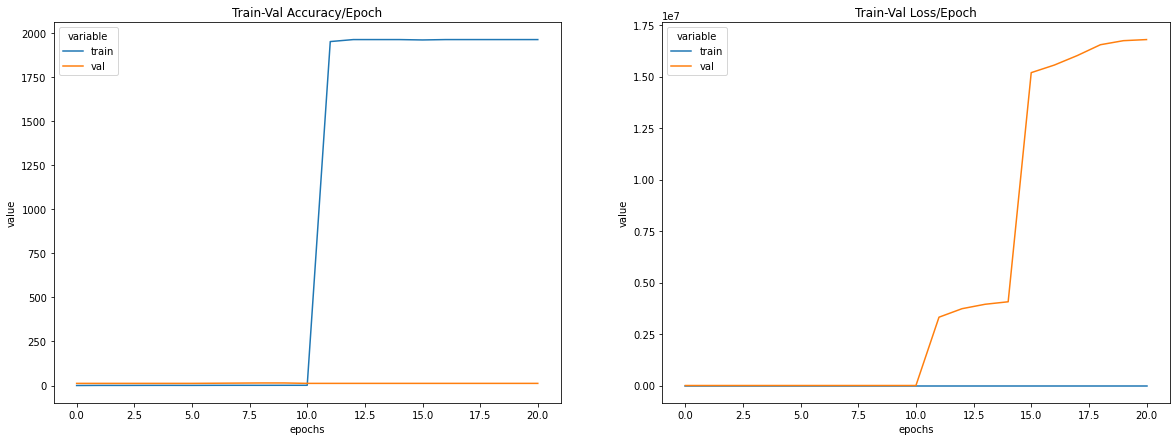

In [140]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [ ]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True)

In [ ]:
print(classification_report(y_test, y_pred_list))